In [3]:
import pandas as pd
import numpy as np
import pyodbc
import statsmodels.api as sm
from dotenv import dotenv_values

# Suppress all warnings
import warnings

warnings.filterwarnings("ignore")



In [4]:
# load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials from .env file
database=environment_variables.get("databasename")
server=environment_variables.get("servername")
login=environment_variables.get("user")
password=environment_variables.get("password")

# create a connection string
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password}"

In [5]:
#Connecting to the Server
connection = pyodbc.connect(connection_string)

In [6]:
# Loading First dataset 3000 records
first_data = pd.read_sql_query(
    "SELECT * FROM dbo.LP2_Telco_churn_first_3000", connection)

# Saving the DataFrame to a CSV file
first_data.to_csv('data/LP2_Telco_churn_first_3000.csv', index=False)

first_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
#Check shape of first_dataset
first_data.shape

(3000, 21)

In [8]:
second_data= pd.read_csv('data/LP2_Telco-churn-second-2000.csv')

#Data preview
second_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [9]:
#Check shape of second_data
second_data.shape

(2043, 21)

In [10]:
# Loading Test data
test_data = pd.read_excel('data\Telco-churn-last-2000.xlsx')

# Data preview
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [11]:
#Merge dataset
merged_df= pd.concat([first_data, second_data])
merged_df.to_csv('merged_df.csv')

In [12]:
# Loading merged_df.csv
merged= pd.read_csv('data\merged_df.csv')

# Data preview
merged.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True
3,3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.64999389648438,True


In [13]:
#Check shape of merged_data
merged.shape

(5043, 22)

In [14]:
#Check merge data info
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5043 non-null   int64  
 1   customerID        5043 non-null   object 
 2   gender            5043 non-null   object 
 3   SeniorCitizen     5043 non-null   int64  
 4   Partner           5043 non-null   object 
 5   Dependents        5043 non-null   object 
 6   tenure            5043 non-null   int64  
 7   PhoneService      5043 non-null   object 
 8   MultipleLines     4774 non-null   object 
 9   InternetService   5043 non-null   object 
 10  OnlineSecurity    4392 non-null   object 
 11  OnlineBackup      4392 non-null   object 
 12  DeviceProtection  4392 non-null   object 
 13  TechSupport       4392 non-null   object 
 14  StreamingTV       4392 non-null   object 
 15  StreamingMovies   4392 non-null   object 
 16  Contract          5043 non-null   object 


In [15]:
#Drop irrelevant column from merged_data
merged = merged.drop('Unnamed: 0', axis = 'columns')

In [16]:
#Confirm dropped column from merged_DataFrame
merged.shape

(5043, 21)

In [17]:
#Check column names in merged_DataFrame
merged.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [18]:
#Checking the data types of the columns
merged.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [19]:
merged.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


- Only about `16.24%` of the customers are senior citizens, suggesting that the company’s customer base is predominantly younger. whereas the `median tenure is 29 months`, indicating that half of the customers stay for `less than 2.5 years`. That not withstanding, the 25th percentile for monthly charges is `$35.78`, while the 75th percentile is `$90.05`. This spread indicates a significant difference in what customers are willing to pay.

In [20]:
# Check for duplicates in merged_data
duplicate_rows = merged.duplicated().sum()

# Print the number of duplicate rows
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [21]:
# loop through columns in training data
for column in merged.columns:
 
    #check if the column is not a numerical column
    if (merged[column].dtype not in ['int64', 'float64']):
 
        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {merged[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: Partner
unique values: ['True' 'False' 'No' 'Yes']
----------------------------------------------------------------------
column: Dependents
unique values: ['False' 'True' 'No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: ['False' 'True' 'Yes' 'No']
----------------------------------------------------------------------
column: MultipleLines
unique values: [nan 'False' 'True' 'No' 'No phone service' 'Yes']
----------------------------------------------------------------------
column: InternetService
unique values: ['DSL' 'Fiber optic' 'No']
--------------------------------------------------------------------

In [22]:
merged.TotalCharges = pd.to_numeric(merged.TotalCharges, errors='coerce')
merged.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [23]:
# Replace 'True' with 'Yes' and 'False' with 'No'
merged.replace({'True': 'Yes', 'False': 'No'}, inplace=True)

In [24]:
# loop through columns in training data
for column in merged.columns:
 
    #check if the column is not a numerical column
    if (merged[column].dtype not in ['int64', 'float64']):
 
        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {merged[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: Partner
unique values: ['Yes' 'No']
----------------------------------------------------------------------
column: Dependents
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: MultipleLines
unique values: [nan 'No' 'Yes' 'No phone service']
----------------------------------------------------------------------
column: InternetService
unique values: ['DSL' 'Fiber optic' 'No']
----------------------------------------------------------------------
column: OnlineSecurity
unique values: ['No' 'Yes' nan 'No

### Univariate Analysis 

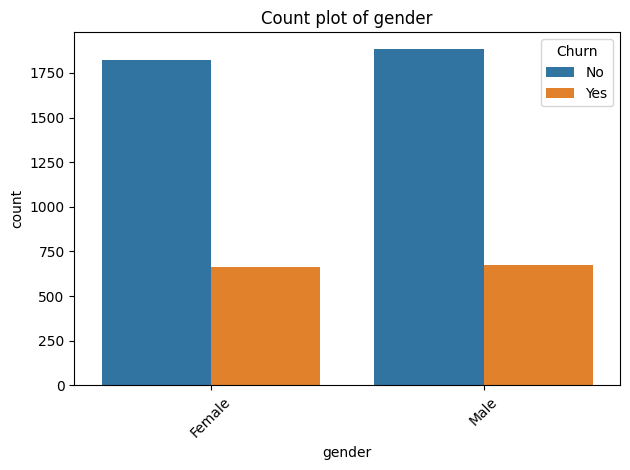

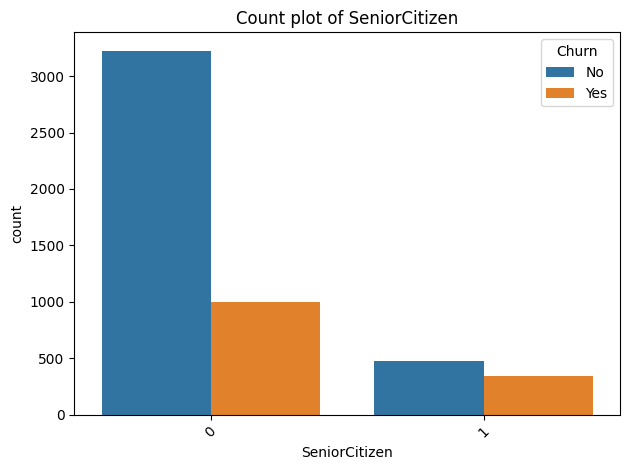

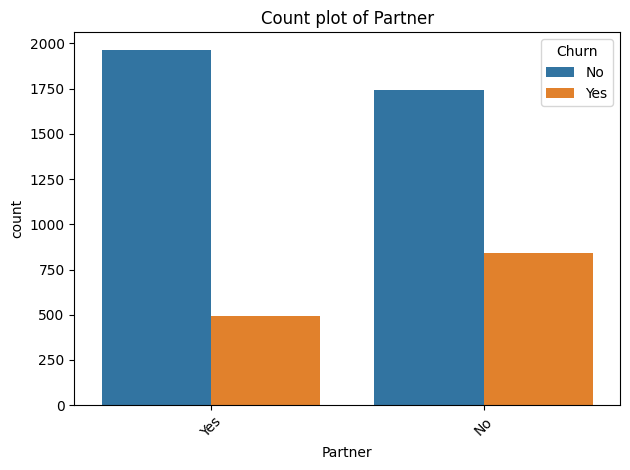

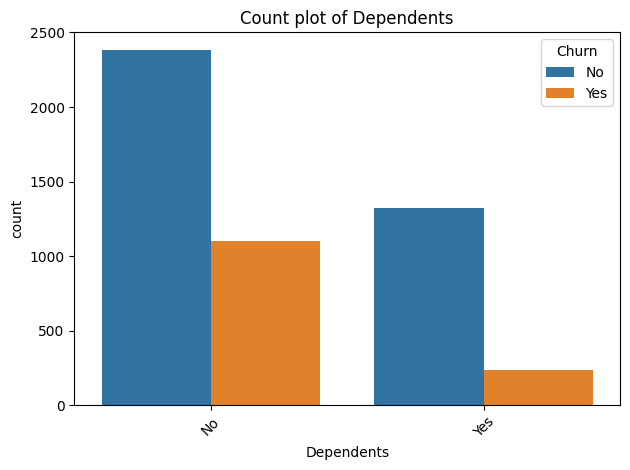

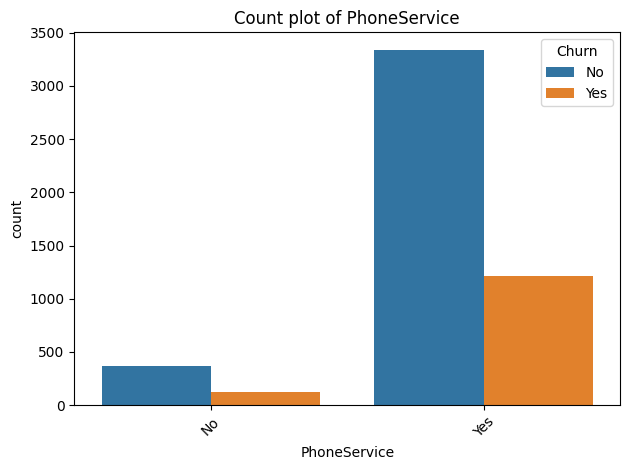

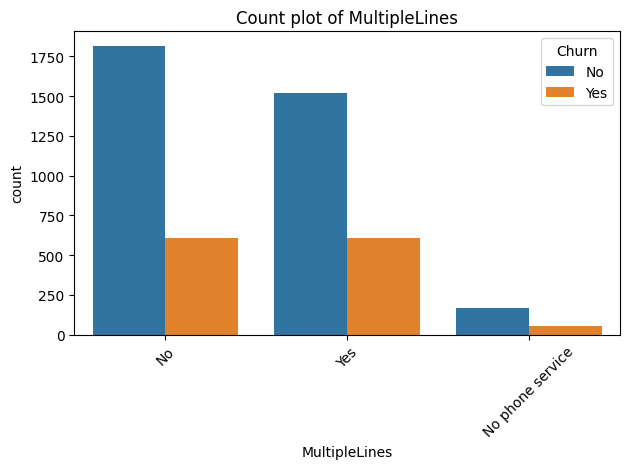

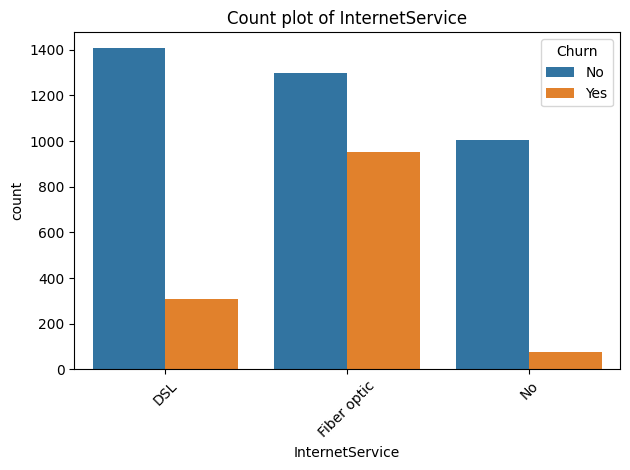

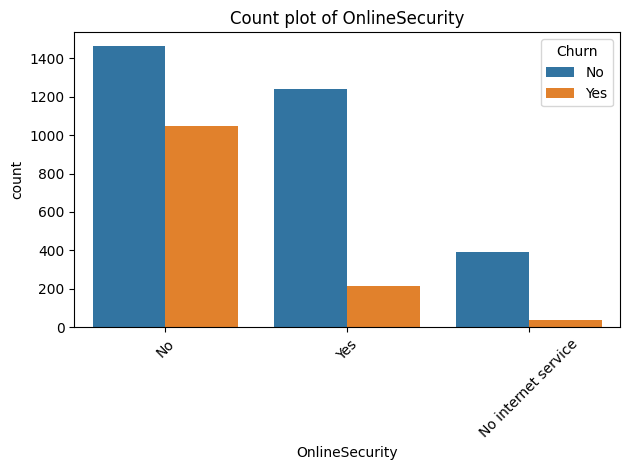

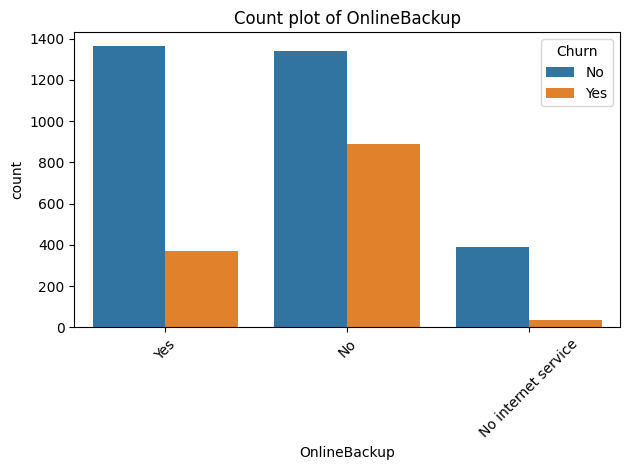

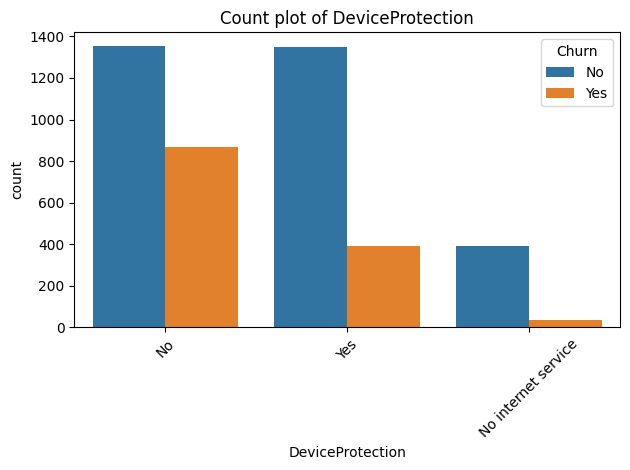

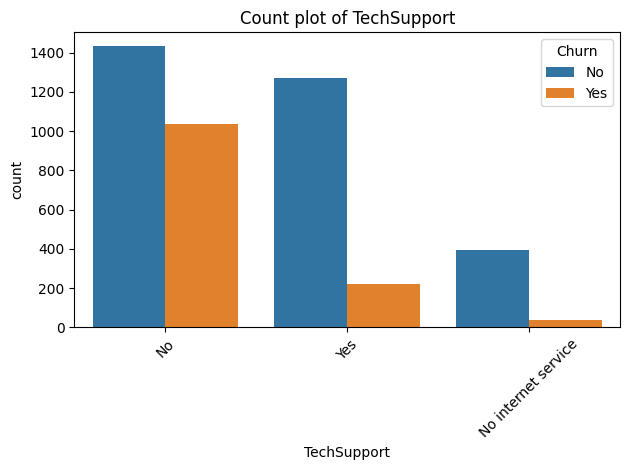

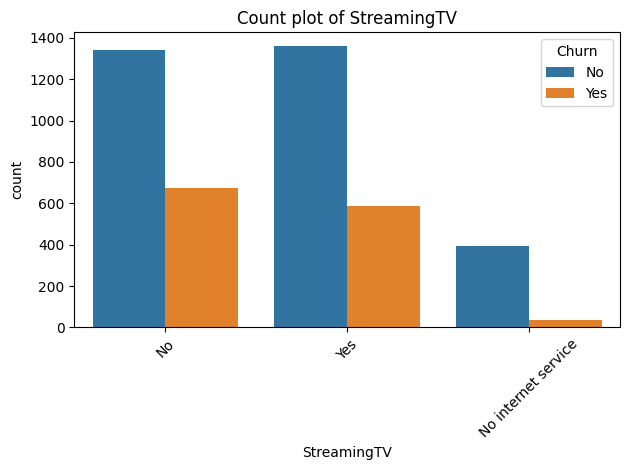

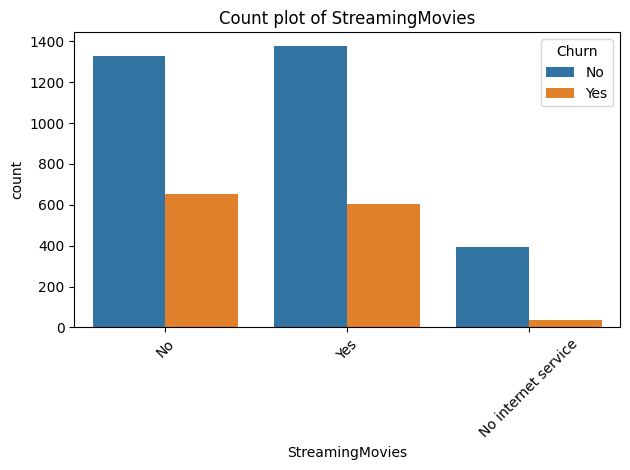

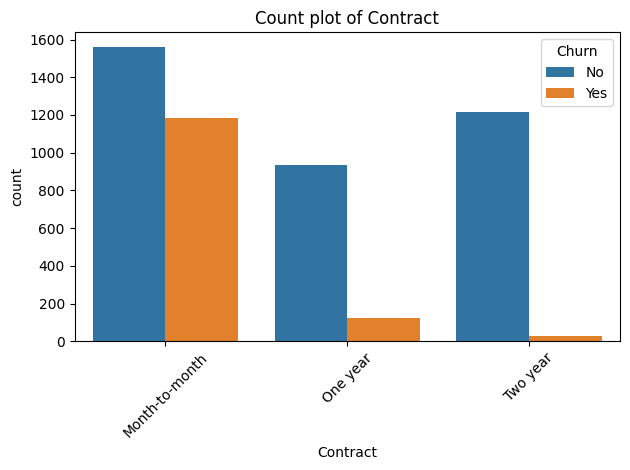

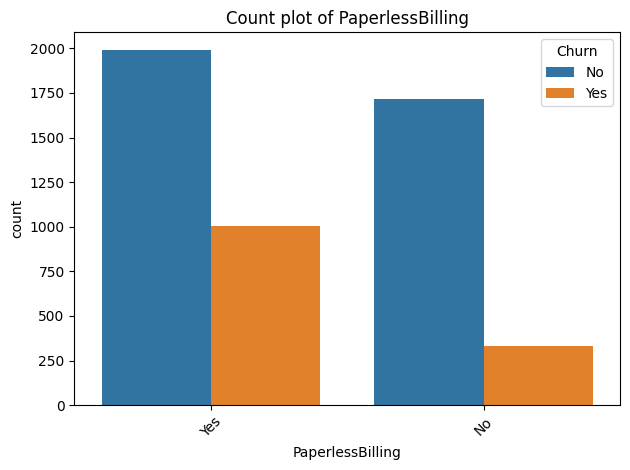

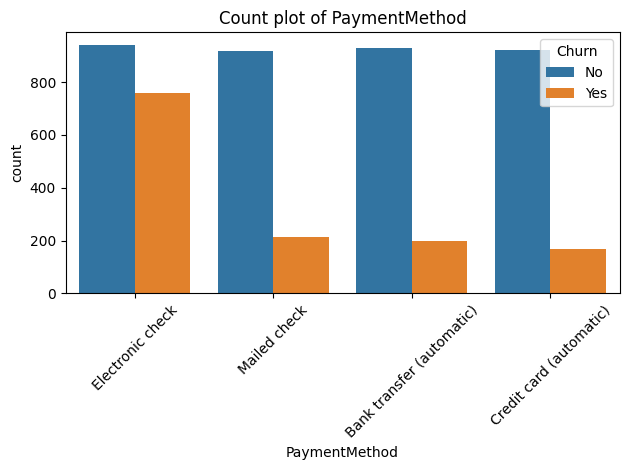

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each categorical predictor and create a count plot with hue set to 'Churn'
for i, predictor in enumerate(merged.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges', 'tenure', 'customerID']).columns):
    
    plt.figure(i)  # Create a new figure for each plot
    sns.countplot(data=merged, x=predictor, hue='Churn')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.title(f'Count plot of {predictor}')  # Optional: Add a title for each plot
    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely

plt.show()  # Display all the plots


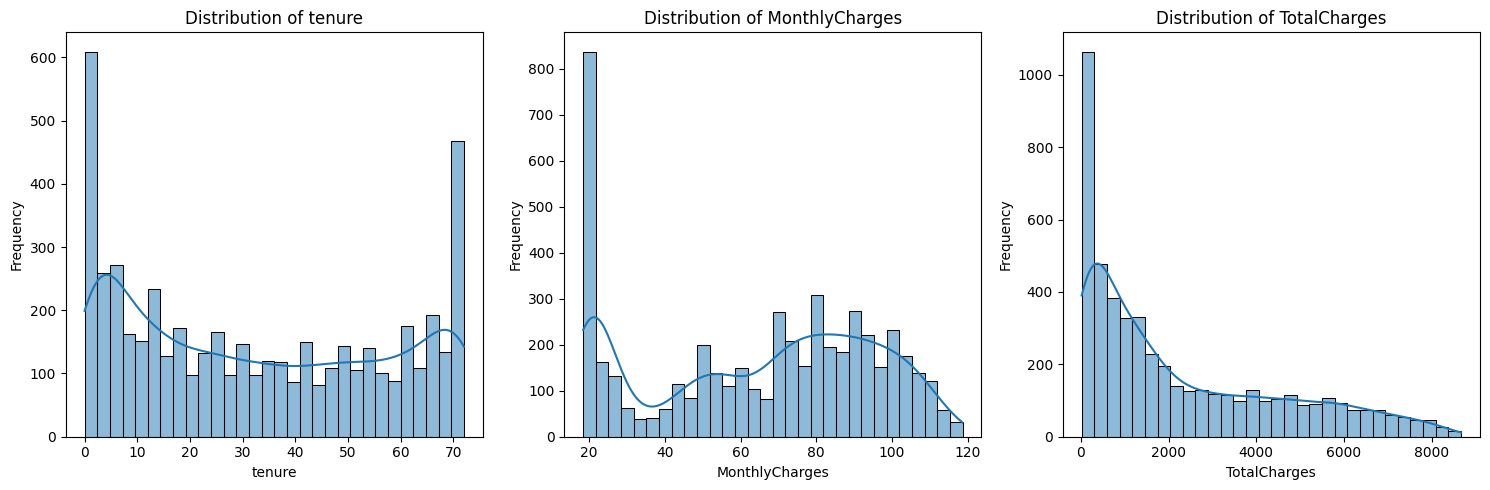

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate numerical columns
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(15, 5))

# Plot histograms for numerical columns in a grid view
for i, column in enumerate(numerical_columns):
    sns.histplot(data=merged, x=column, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### `Key insights`
1. There are 3000 rows and 21 columns in the first dataset.
2. There are 2000 rows and 21 columns in the second dataset.
3. There are 5000 rows and 21 columns in the merged dataset.
4. Drop irrelevant Unamed:0 column from the merged dataset
5. TotalCharges has wrong Dtype instead of float.
6. The following columns have missing values:
     - MultipleLines        269
     - OnlineSecurity       651
     - OnlineBackup         651
     - DeviceProtection     651
     - TechSupport          651
     - StreamingTV          651
     - StreamingMovies      651
     - TotalCharges          8
     - Churn                 1
